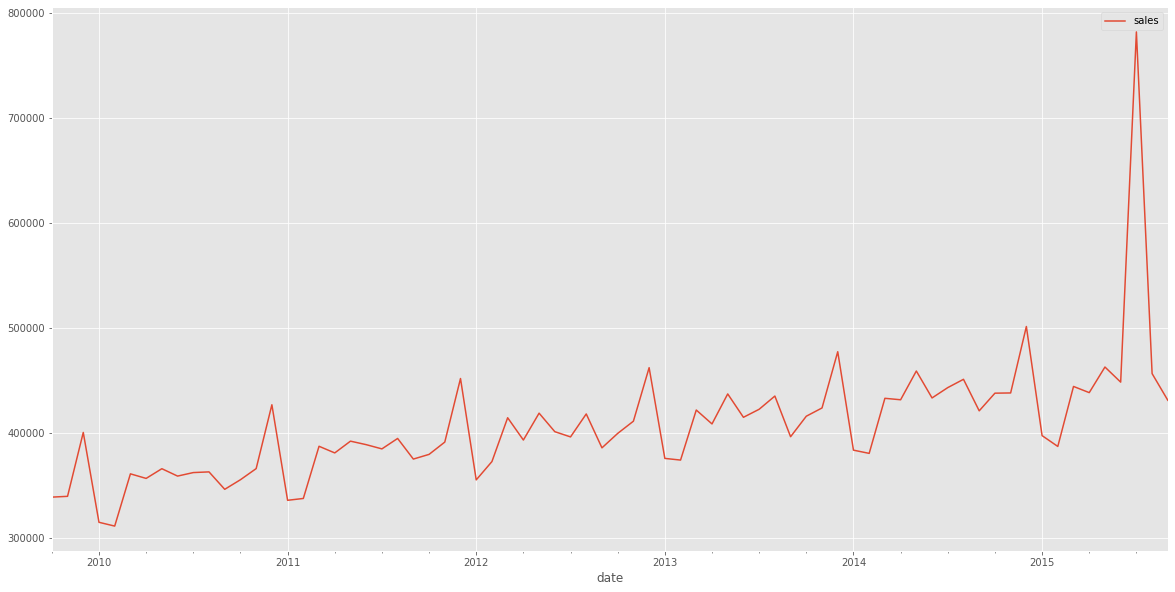

In [112]:
### Initial imports to get started.

import pandas as pd
import matplotlib.pylab as plt
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

sales_data = pd.read_csv('C:\\Users\\cmozk\\Documents\\MFE docs\\230p\\salesdataHW2.csv')
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)

sales_data.plot()

The data point towards July 2015 was changed to make it an anomaly, as you can notice a sudden spike there 

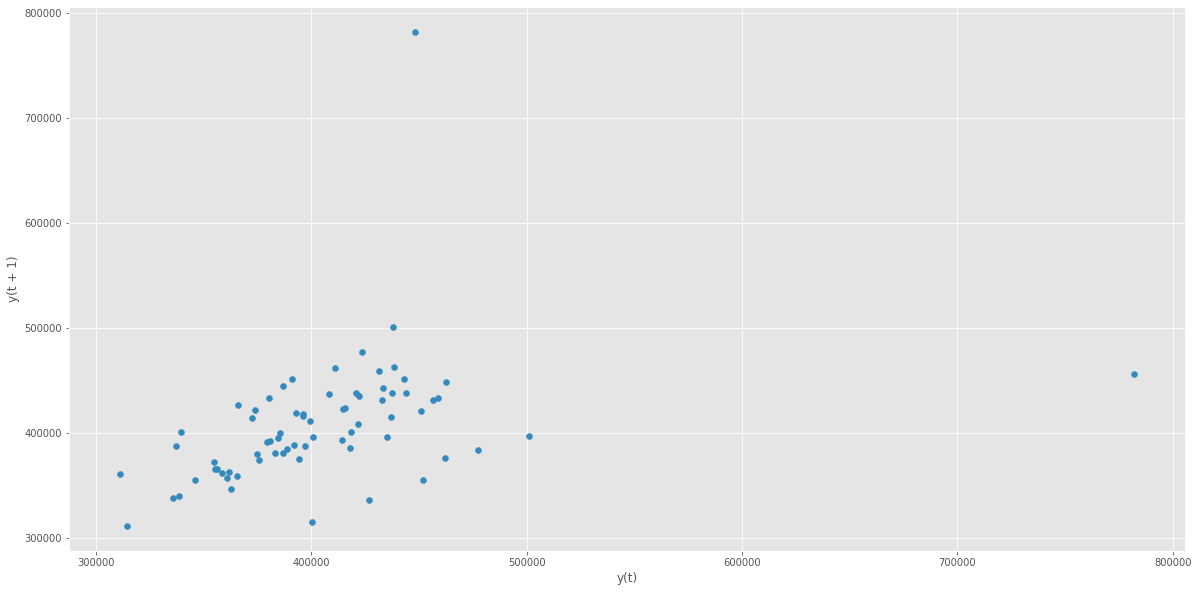

In [113]:
from pandas.plotting import lag_plot
lag_plot(sales_data)
plt.show()
#pd.tools.plotting.lag_plot(sales_data['sales'])

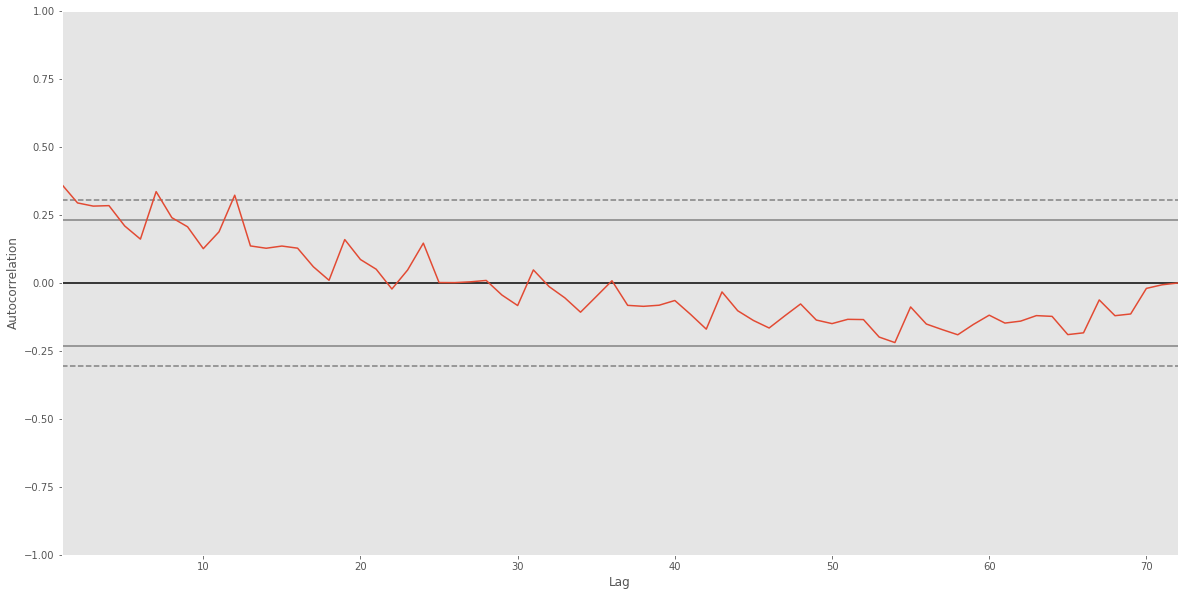

In [114]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(sales_data)
plt.show()

In [115]:
sales_data['sales'].corr(sales_data['sales'].shift(12))

0.7010198903978041

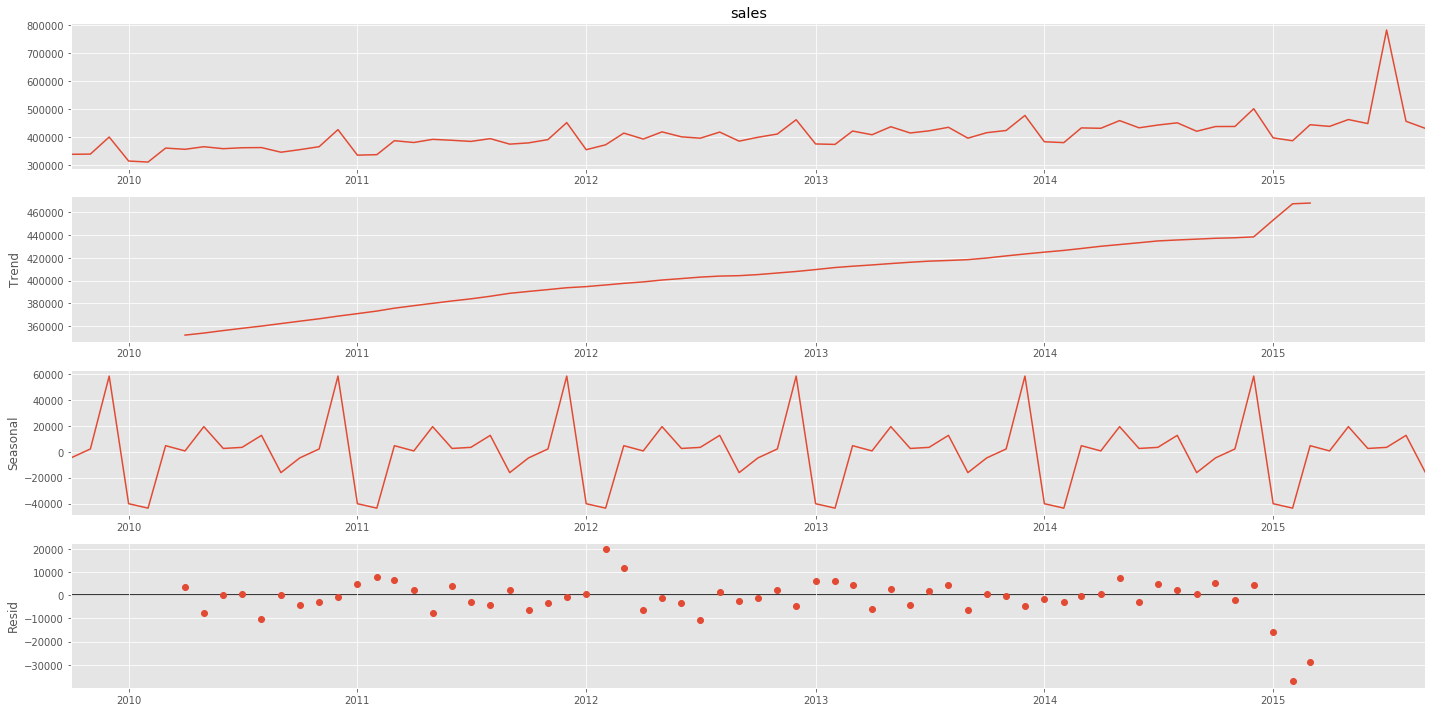

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(sales_data['sales'], model='additive')
x = decomposed.plot() #See note below about this

We can see in the residue chart that some of the points are far away from other points 

In [117]:
sales_data['stationary']=sales_data['sales'].diff()

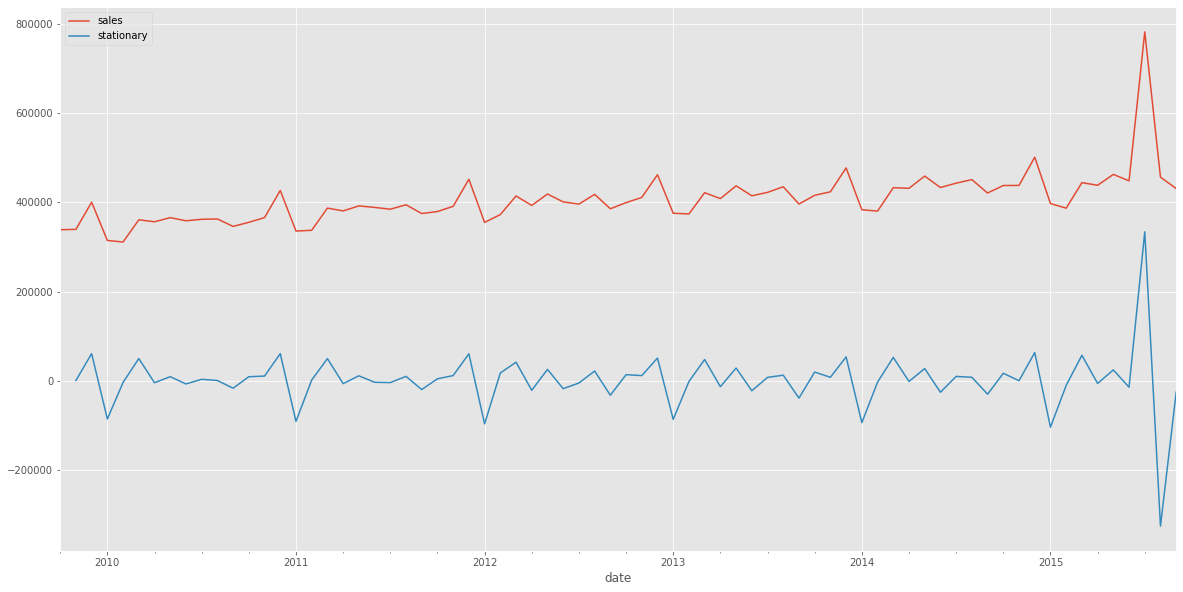

In [118]:
sales_data.plot()

In [119]:
from statsmodels.tsa.ar_model import AR

#create train/test datasets
X = sales_data['stationary'].dropna()
train_data = X[1:len(X)-12]
test_data = X[X[len(X)-12:]]

#train the autoregression model
model = AR(train_data)
model_fitted = model.fit()

C:\Users\cmozk\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)


C:\Users\cmozk\anaconda3\lib\site-packages\statsmodel

In [120]:
print('The lag value chose is: %s' % model_fitted.k_ar)

The lag value chose is: 10


In [121]:
print('The coefficients of the model are:\n %s' % model_fitted.params)

The coefficients of the model are:
 const             7720.952626
L1.stationary       -1.297636
L2.stationary       -1.574980
L3.stationary       -1.403045
L4.stationary       -1.123204
L5.stationary       -0.472200
L6.stationary       -0.014586
L7.stationary        0.564099
L8.stationary        0.792080
L9.stationary        0.843242
L10.stationary       0.395546
dtype: float64


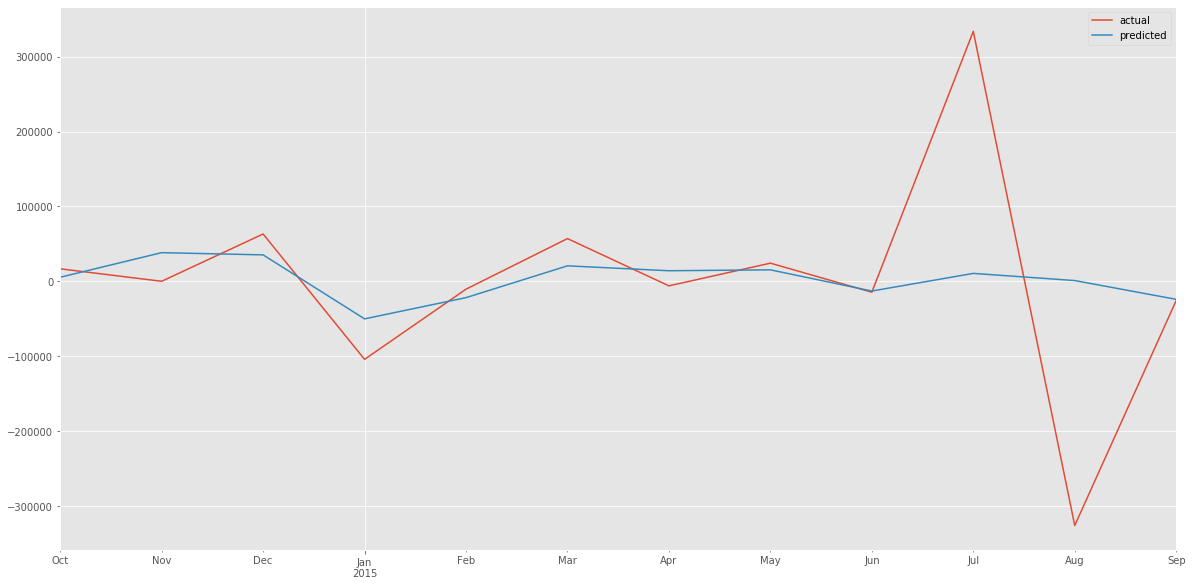

In [122]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [sales_data['stationary'].tail(12),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()

In [123]:
from sklearn.metrics import r2_score

r2 = r2_score(sales_data['stationary'].tail(12), predictions)

In [124]:
r2

0.08009429366268284

In [125]:
import numpy as np
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    df = df.sort_values(by='load_date', ascending=False)
    #df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%m/%d/%Y")
    return df

We find 7 period rolling mean, and define 3 envelops which are  1.5,1.75 and 2 standard deviations away from the mean

In [126]:

sales_data["predicted"]=predictions
sales_data["actuals"]=sales_data["stationary"]

sales_data1 = pd.read_csv('C:\\Users\\cmozk\\Documents\\MFE docs\\230p\\salesdataHW2.csv')
sales_data["load_date"]=sales_data1["date"]

classify_df=detect_classify_anomalies(sales_data,7)


In [127]:
classify_df.to_csv("C:\\Users\\cmozk\\Documents\\MFE docs\\230p\\checker.csv")

In [129]:
sales_data2=pd.read_csv("C:\\Users\\cmozk\\Documents\\MFE docs\\230p\\checker1.csv")

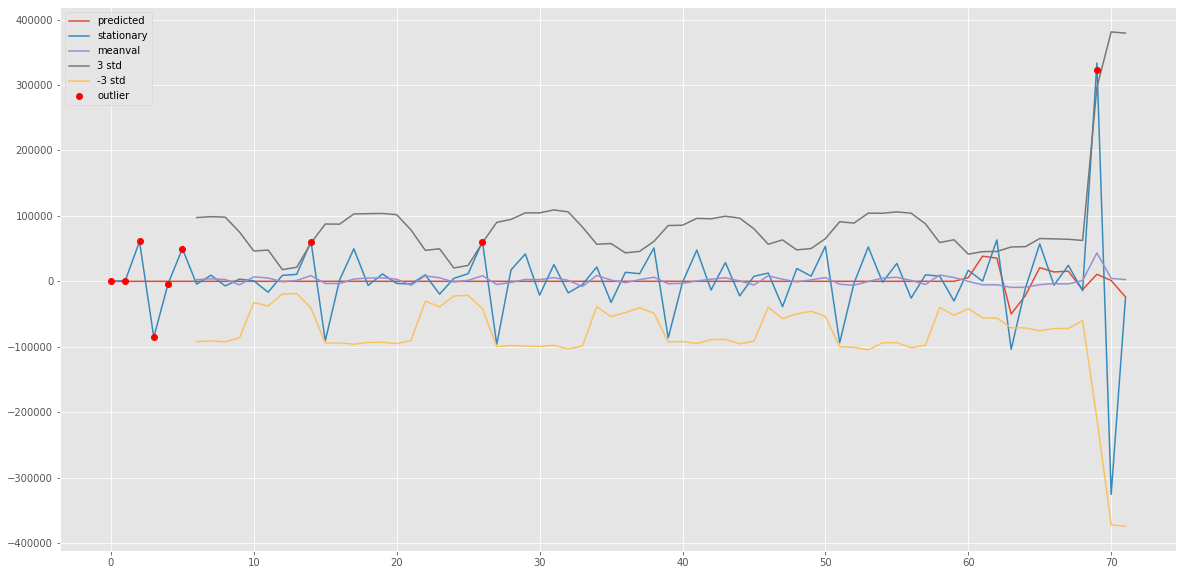

In [138]:
plt.plot(sales_data2["predicted"],label="predicted")
plt.plot(sales_data2["stationary"],label="stationary")
plt.plot(sales_data2["meanval"],label="meanval")
plt.plot(sales_data2["3s"],label="3 std")
plt.plot(sales_data2["-3s"],label="-3 std")
plt.plot(sales_data2["anomaly_points"],'ro',label="outlier")
plt.legend(loc="upper left")

We can see our anomaly point detected in the end